<a href="https://colab.research.google.com/github/ha405/Urdu-News-Classification/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> MODEL IMPLEMENTATIONS <h1>

<h2> Imports <h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import cupy as cp
import sklearn

<h2> Import and Split <h2>

In [3]:
path = r"Dataset/articles.csv"
data = pd.read_csv(path)
# print(data.head())

In [4]:
X = data['content']
Y = data['gold_label']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")


category_to_label = {
    "entertainment": 0,
    "business": 1,
    "sports": 2,
    "science-technology": 3,
    "international": 4
}

Y_train = [category_to_label[label.strip()] for label in Y_train if label.strip() in category_to_label]
Y_test = [category_to_label[label.strip()] for label in Y_test if label.strip() in category_to_label]


X_train shape: (1594,)
X_test shape: (399,)
Y_train shape: (1594,)
Y_test shape: (399,)


<h2> Bag of Words <h2>


In [5]:
class TextProcessor:
    def __init__(self, dataset):
        self.dataset = dataset
        self.vocabulary = {}

    def build_vocabulary(self):
        unique_words = set()
        for sentence in self.dataset:
            unique_words.update(sentence.split())
        self.vocabulary = {word: idx for idx, word in enumerate(sorted(unique_words))}
        return self.vocabulary

    def sentence_to_bow(self, sentence):
        words = sentence.split()
        vector = np.zeros(len(self.vocabulary))
        for word in words:
            if word in self.vocabulary:
                index = self.vocabulary[word]
                # print(index)
                vector[index] += 1
        return vector

    def vectorize_sentences(self, X):
        return [self.sentence_to_bow(sentence) for sentence in X]


In [6]:
bag = TextProcessor(X_train)
vocab = bag.build_vocabulary()
train_x = bag.vectorize_sentences(X_train)
test_x = bag.vectorize_sentences(X_test)
# print("trainx", train_x[0][12242])
# print(vocab)

<h2> Neural Network Using Pytorch <h2>

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
train_x_t = torch.tensor(train_x, dtype=torch.float32)
test_x_t = torch.tensor(test_x, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.long)
Y_test_t = torch.tensor(Y_test, dtype=torch.long)

train_dataset = TensorDataset(train_x_t,Y_train_t)
test_dataset = TensorDataset(test_x_t,Y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class NewsClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)    
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.9) 
        self.dropout1 = nn.Dropout(0.1)         
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout1(x)
        x = F.relu(self.fc3(x))
        # x = self.dropout(x)
        x = self.fc4(x)
        return x


In [25]:
input_size = train_x_t.shape[1]
num_classes = len(Y_train_t.unique())
model = NewsClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
num_epochs = 20
train_losses = []  
train_accuracies = []  

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch_x, batch_y in train_loader:
        output = model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == batch_y).sum().item()
        total_samples += batch_y.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100

    # Store loss and accuracy for this epoch
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.2f}%")


Epoch [1/20], Loss: 1.4492, Train Accuracy: 42.97%
Epoch [2/20], Loss: 0.5890, Train Accuracy: 83.63%
Epoch [3/20], Loss: 0.2977, Train Accuracy: 91.97%
Epoch [4/20], Loss: 0.2454, Train Accuracy: 94.04%
Epoch [5/20], Loss: 0.1620, Train Accuracy: 96.17%
Epoch [6/20], Loss: 0.1237, Train Accuracy: 96.61%
Epoch [7/20], Loss: 0.1152, Train Accuracy: 97.43%
Epoch [8/20], Loss: 0.0932, Train Accuracy: 97.62%
Epoch [9/20], Loss: 0.0782, Train Accuracy: 97.99%
Epoch [10/20], Loss: 0.0792, Train Accuracy: 97.24%
Epoch [11/20], Loss: 0.0629, Train Accuracy: 98.68%
Epoch [12/20], Loss: 0.0558, Train Accuracy: 98.18%
Epoch [13/20], Loss: 0.0558, Train Accuracy: 98.81%
Epoch [14/20], Loss: 0.0691, Train Accuracy: 98.68%
Epoch [15/20], Loss: 0.0506, Train Accuracy: 98.93%
Epoch [16/20], Loss: 0.0321, Train Accuracy: 98.93%
Epoch [17/20], Loss: 0.0310, Train Accuracy: 99.25%
Epoch [18/20], Loss: 0.0516, Train Accuracy: 98.81%
Epoch [19/20], Loss: 0.0465, Train Accuracy: 98.87%
Epoch [20/20], Loss: 

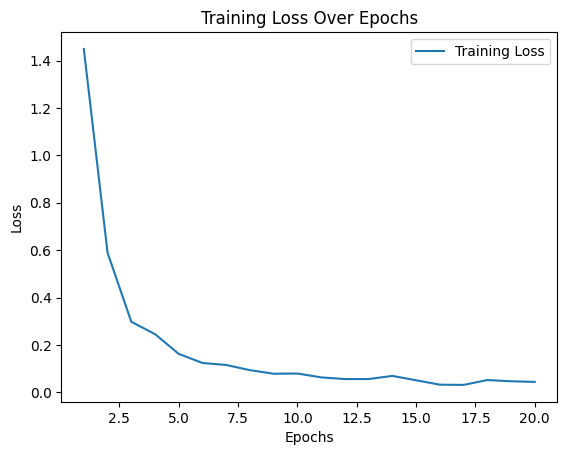

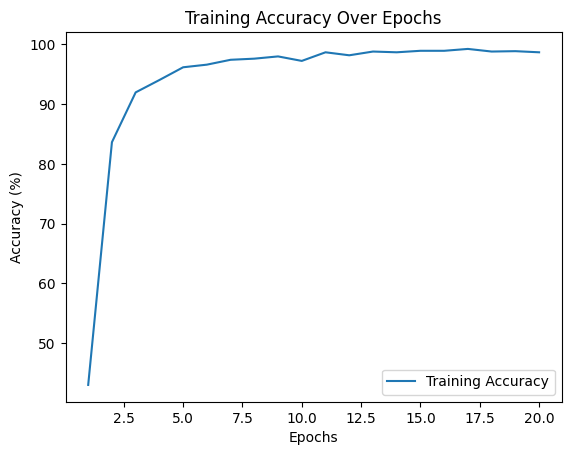

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plotting Loss
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plotting Accuracy
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()


In [30]:
def evaluate_model(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x,batch_y in test_loader:
            output = model(batch_x)
            _,predicted = torch.max(output,1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = correct / total
    return accuracy

test_accuracy = evaluate_model(test_loader, model)
print(f"Test Accuracy: {test_accuracy*100:.1f}")


Test Accuracy: 97.5


Use these for next models, all are in vector forms already and labels are also in represented numerically in Y_test, Y_train.

In [ ]:
# train_x,test_x,Y_test,Y_train
# vocab # for vocabulary of words
# Import necessary libraries
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Ensure train_x and test_x are NumPy arrays
train_x = np.array(train_x)
test_x = np.array(test_x)

# Dictionary to store model accuracies
model_accuracies = {}

# 1. K-Nearest Neighbors (KNN)
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier

# Ensure train_x and test_x are NumPy arrays
train_x = np.array(train_x)
test_x = np.array(test_x)

# Dictionary to store model accuracies
model_accuracies = {}

print("\nRunning Support Vector Machine (SVM) Classifier...")
svm_model = SVC(
    kernel='linear',   # You can also try 'rbf', 'poly', or 'sigmoid' kernels
    C=1.0,             # Regularization parameter; lower C means stronger regularization
    random_state=42    # Ensures reproducibility
)
svm_model.fit(train_x, Y_train)
svm_predictions = svm_model.predict(test_x)
svm_accuracy = accuracy_score(Y_test, svm_predictions)
model_accuracies['SVM'] = svm_accuracy

# Output evaluation results
print(f"SVM Accuracy: {svm_accuracy:.2f}")
print("\nClassification Report:")

# 1. K-Nearest Neighbors (KNN)
print("\nRunning KNN Classifier...")
knn_model = KNeighborsClassifier(n_neighbors=1)  # You can adjust the number of neighbors
knn_model.fit(train_x, Y_train)
knn_predictions = knn_model.predict(test_x)
knn_accuracy = accuracy_score(Y_test, knn_predictions)
model_accuracies['KNN'] = knn_accuracy
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:\n", classification_report(Y_test, knn_predictions))

# 2. Logistic Regression
print("\nRunning Logistic Regression...")
logistic_model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
logistic_model.fit(train_x, Y_train)
logistic_predictions = logistic_model.predict(test_x)
logistic_accuracy = accuracy_score(Y_test, logistic_predictions)
model_accuracies['Logistic Regression'] = logistic_accuracy
print(f"Logistic Regression Accuracy: {logistic_accuracy:.2f}")
print("Logistic Regression Classification Report:\n", classification_report(Y_test, logistic_predictions))

# 3. Multinomial Naive Bayes
print("\nRunning Multinomial Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(train_x, Y_train)
nb_predictions = nb_model.predict(test_x)
nb_accuracy = accuracy_score(Y_test, nb_predictions)
model_accuracies['Multinomial Naive Bayes'] = nb_accuracy
print(f"Multinomial Naive Bayes Accuracy: {nb_accuracy:.2f}")
print("Multinomial Naive Bayes Classification Report:\n", classification_report(Y_test, nb_predictions))

# 4. Random Forest Classifier
print("\nRunning Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators
rf_model.fit(train_x, Y_train)
rf_predictions = rf_model.predict(test_x)
rf_accuracy = accuracy_score(Y_test, rf_predictions)
model_accuracies['Random Forest'] = rf_accuracy
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print("Random Forest Classification Report:\n", classification_report(Y_test, rf_predictions))

# Print summary of accuracies for all models
print("\nModel Accuracies Summary:")
for model_name, accuracy in model_accuracies.items():
    print(f"{model_name}: {accuracy:.2f}")



Running Support Vector Machine (SVM) Classifier...


NameError: name 'SVC' is not defined

In [32]:
#logistical regression with L2 regularization
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

class SoftmaxRegression:
    def __init__(self, learning_rate=0.005, n_iterations=2000, regularization_strength=0.05, batch_size=32, dropout_rate=0.2):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization_strength = regularization_strength
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.weights = None
        self.bias = None

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(n_samples), y_true])
        loss = np.sum(log_likelihood) / n_samples
        reg_term = (self.regularization_strength / 2) * np.sum(self.weights ** 2)
        return loss + reg_term

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = np.max(y) + 1
        self.weights = np.random.randn(n_features, n_classes) * np.sqrt(2 / (n_features + n_classes))
        self.bias = np.zeros(n_classes)


        y_one_hot = np.zeros((n_samples, n_classes))
        y_one_hot[np.arange(n_samples), y] = 1

        for epoch in range(self.n_iterations):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            for i in range(0, n_samples, self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                X_batch = X[batch_indices]
                y_batch = y_one_hot[batch_indices]

                #dropout apply kardo to prevent overfitting
                X_batch = X_batch * (np.random.rand(*X_batch.shape) > self.dropout_rate)


                linear_model = np.dot(X_batch, self.weights) + self.bias
                y_pred = self.softmax(linear_model)


                dw = (1 / self.batch_size) * np.dot(X_batch.T, (y_pred - y_batch)) + self.regularization_strength * self.weights
                db = (1 / self.batch_size) * np.sum(y_pred - y_batch, axis=0)


                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db


            # if epoch % 100 == 0:
            #     loss = self.cross_entropy_loss(y, self.softmax(np.dot(X, self.weights) + self.bias))
            #     print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(linear_model)
        return np.argmax(y_pred, axis=1)


# Train and evaluate the model(yahan we can make changes to the hyperparameters)
softmax_model = SoftmaxRegression(
    learning_rate=0.002,  #isko change karkay dheksaktay hain to improve accuracy
    n_iterations=2000,
    regularization_strength=0.05,
    batch_size=32,
    dropout_rate=0.2
)

softmax_model.fit(train_x, Y_train)
y_pred = softmax_model.predict(test_x)

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


Epoch 0, Loss: 1.5866
Epoch 100, Loss: 0.4253
Epoch 200, Loss: 0.3580
Epoch 300, Loss: 0.3357
Epoch 400, Loss: 0.3276
Epoch 500, Loss: 0.3248
Epoch 600, Loss: 0.3236
Epoch 700, Loss: 0.3232
Epoch 800, Loss: 0.3231
Epoch 900, Loss: 0.3231
Epoch 1000, Loss: 0.3229
Epoch 1100, Loss: 0.3229
Epoch 1200, Loss: 0.3231
Epoch 1300, Loss: 0.3230
Epoch 1400, Loss: 0.3230
Epoch 1500, Loss: 0.3232
Epoch 1600, Loss: 0.3230
Epoch 1700, Loss: 0.3230
Epoch 1800, Loss: 0.3231
Epoch 1900, Loss: 0.3229
Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.94      0.95        67
           2       1.00      0.98      0.99        98
           3       0.93      0.93      0.93        88
           4       0.92      0.97      0.95        74

    accuracy                           0.96       399
   macro avg       0.96      0.96      0.96       399
weighted avg       0.96      0.96      